Practice 4 Notebook on processed data vol 2

*This is a kaggle notebook*

# Importing the libraries

First of all we'll install `fastparquet` module. 

Fastparquet is a python implementation of the [parquet format](https://github.com/apache/parquet-format), aiming integrate into python-based big data work-flows. It is used implicitly by the projects Dask, Pandas and intake-parquet.

In [1]:
!pip install fastparquet

In [2]:
import os
import string
from typing import List
import warnings
import numpy as np
import pandas as pd
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
from copy import deepcopy
import nltk
import spacy
import re

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/proccessed-geo-location-datasets
/kaggle/input/mantis-analytics-location-detection


In [4]:
# Check for CUDA availability for GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device {device}')

device cuda


In [5]:
project_path = '/kaggle/input/mantis-analytics-location-detection/'

ru_geo_path = project_path + 'ru_geo_dataset.csv'
uk_geo_path = project_path + 'uk_geo_dataset.csv'
test_path = project_path + 'test.csv'

project_path_processed = '/kaggle/input/proccessed-geo-location-datasets/'

uk_geo_path_processed = project_path_processed + 'uk_geo_processed.parquet'

In [6]:
ru_geo_dataset = pd.read_csv(ru_geo_path, converters={"loc_markers": eval})

In [7]:
num_parts = 9
part_size = len(ru_geo_dataset) // num_parts

# Initialize an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

for part in range(7, num_parts):
    start_idx = part * part_size
    end_idx = (part + 1) * part_size if part < num_parts - 1 else len(ru_geo_dataset)
    
    geo_subset = ru_geo_dataset[start_idx:end_idx]

    combined_df = pd.concat([combined_df, geo_subset])


In [8]:
ru_geo_dataset = combined_df

In [9]:
uk_geo_dataset = pd.read_csv(uk_geo_path, converters={"loc_markers": eval})

uk_geo_dataset["language"] = "ukr"
ru_geo_dataset["language"] = "rus"

ru_geo_dataset['is_valid'] = 0
ru_geo_dataset['is_valid'][1700000:] = 1

geo_dataset = pd.concat([ru_geo_dataset, uk_geo_dataset]).reset_index(drop=True)

/tmp/ipykernel_292/3336987723.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ru_geo_dataset['is_valid'][1700000:] = 1


In [10]:
# ru_geo_dataset
# uk_geo_dataset

geo_dataset

geo_dataset.drop(['doc_id', 'sent_id'], axis =1, inplace=True)

# A bit of EDA

In [11]:
# Display basic statistics of uk_geo_dataset
print(geo_dataset.info())
print(geo_dataset.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2794189 entries, 0 to 2794188
Data columns (total 6 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   text         object
 1   loc_markers  object
 2   org_markers  object
 3   per_markers  object
 4   language     object
 5   is_valid     int64 
dtypes: int64(1), object(5)
memory usage: 127.9+ MB
None
           is_valid
count  2.794189e+06
mean   3.370889e-02
std    1.804788e-01
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.000000e+00


In [12]:
# Display basic statistics of ru_geo_dataset
# print(ru_geo_dataset.info())
# print(ru_geo_dataset.describe())

In [13]:
# Check the class distribution in uk_geo_dataset
class_distribution = geo_dataset['is_valid'].value_counts()
print(class_distribution)

is_valid
0    2700000
1      94189
Name: count, dtype: int64


In [14]:
# Check for missing values in both datasets
print("Missing values in uk_geo_dataset:")
print(geo_dataset.isnull().sum())

# print("Missing values in ru_geo_dataset:")
# print(ru_geo_dataset.isnull().sum())

Missing values in uk_geo_dataset:
text           0
loc_markers    0
org_markers    0
per_markers    0
language       0
is_valid       0
dtype: int64


Well that's a blessing ... for now ;)

In [15]:
# Analyze text length
geo_dataset['text_length'] = geo_dataset['text'].apply(len)
print(geo_dataset['text_length'].describe())

# Analyze location markers
geo_dataset['num_loc_markers'] = geo_dataset['loc_markers'].apply(len)
print(geo_dataset['num_loc_markers'].describe())

count    2.794189e+06
mean     1.198027e+02
std      5.923723e+01
min      1.000000e+00
25%      7.600000e+01
50%      1.090000e+02
75%      1.530000e+02
max      1.309000e+03
Name: text_length, dtype: float64
count    2.794189e+06
mean     4.518449e-01
std      8.780597e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      4.700000e+01
Name: num_loc_markers, dtype: float64


In [16]:
geo_dataset

,text,loc_markers,org_markers,per_markers,language,is_valid,text_length,num_loc_markers
0,Народно-патриотическая партия России была заре...,[],"[(0, 36)]",[],rus,0,80,0
1,Председатель партии - депутат Госдумы из фракц...,[],"[(30, 37), (50, 110)]",[],rus,0,112,0
2,С первого января 2007 года Росрегистрация обра...,[],"[(27, 41)]",[],rus,0,138,0
3,Все иски были удовлетворены.,[],[],[],rus,0,28,0
4,"Атакующий полузащитник ""Милана"" и сборной Браз...","[(42, 50)]","[(24, 30)]","[(51, 55), (147, 151)]",rus,0,152,1
...,...,...,...,...,...,...,...,...
2794184,"Траєкторія польоту цих літаків є провокуючою”,...",[],[],"[(56, 63)]",ukr,1,64,0
2794185,Якщо порівняти у відсотковому співвідношенні к...,[],[],[],ukr,1,169,0
2794186,"У інфікувалися четверо жінок, наймолодшій із н...",[],[],[],ukr,1,153,0
2794187,"Хочу запевнити, що створення Православної Церк...",[],"[(29, 56)]",[],ukr,1,127,0


In [17]:
# Let's explore example texts
sample_data = geo_dataset.sample(5)
for index, row in sample_data.iterrows():
    text = row['text']
    loc_markers = row['loc_markers']
    print(f"Text: {text}")
    print(f"Location Markers: {loc_markers}\n")


Text: По его мнению, намерения Шарона вывести израильские войска из сектора Газа и демонтировать находящиеся там израильские поселения, несмотря на все давление израильских правых, является "хорошим знаком на пути к миру".
Location Markers: [(70, 74)]

Text: В подземном переходе под Сущевским валом священнослужители привлекли внимание группы молодых людей в возрасте от 16 до 25 лет.
Location Markers: [(25, 40)]

Text: У команді кандидата в президенти України Гриценка в 2019 році - кандидат на посаду міністра оборони.
Location Markers: [(33, 40)]

Text: Официально ее первый президентский срок истекает только 7 июля.
Location Markers: []

Text: В охранных частях - 22 процента.
Location Markers: []



From the last two we can see that not every row from `text` column contains a location in it. Let's find out how many rows do we have in the dataset that DO contain a location.

In [18]:
(geo_dataset["num_loc_markers"] == 0).value_counts()

num_loc_markers
True     1957088
False     837101
Name: count, dtype: int64

True here means that in the sentense there is no location mentioned;

False - that the location is mentioned.

num_loc_markers
0     1957088
1      561828
2      187016
3       57081
4       18218
5        6485
6        2815
7        1415
8         819
9         491
10        296
11        171
12        107
13         79
16         50
14         49
15         41
17         24
19         22
18         16
20         13
21          9
25          7
26          6
23          6
22          5
29          5
24          5
27          4
34          3
33          2
35          2
31          2
30          2
28          2
37          1
32          1
38          1
36          1
47          1
Name: count, dtype: int64

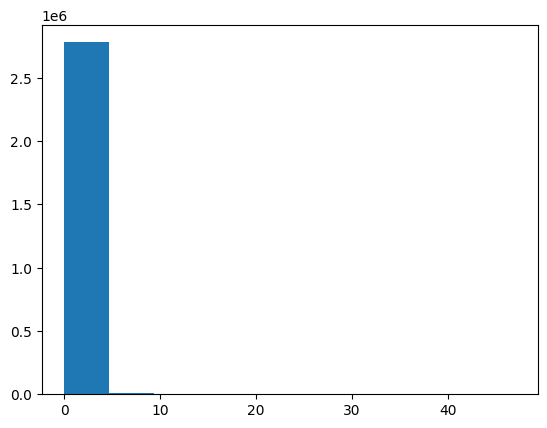

In [19]:
# Distribution of Number of locations
plt.hist(geo_dataset["num_loc_markers"])

geo_dataset["num_loc_markers"].value_counts()

<Axes: >

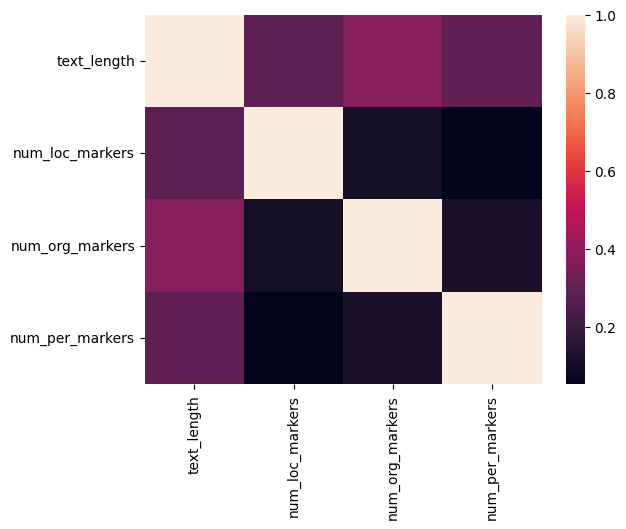

In [20]:
geo_dataset['num_org_markers'] = geo_dataset['org_markers'].apply(len)
geo_dataset['num_per_markers'] = geo_dataset['per_markers'].apply(len)

corr_ = geo_dataset[['text_length', 'num_loc_markers', 'num_org_markers', 'num_per_markers']]

sns.heatmap(corr_.corr())

We can see that number of loc_markers poorly corelates with other numeric features

## Validation

In [21]:
geo_dataset, geo_dataset_hodlout_test = geo_dataset[geo_dataset["is_valid"] == 0].reset_index(drop=True), geo_dataset[geo_dataset["is_valid"] == 1].reset_index(drop=True)

In Lection 4 we used StratifiedKFold by number of locations, which is a great way of validation. 

Yet here I'd like to use stratification by whether the text contains a location or not.

In [22]:
# geo_dataset["stratify_col"] = geo_dataset["num_loc_markers"]
# geo_dataset.loc[geo_dataset["number_of_locations"] >= 14, "stratify_col"] = -1 

geo_dataset["stratify_col"] = (geo_dataset["num_loc_markers"] == 0)

In [23]:
geo_dataset["stratify_col"].value_counts()

stratify_col
True     1895853
False     804147
Name: count, dtype: int64

In [24]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(geo_dataset, geo_dataset["stratify_col"])]

In [25]:
X_train_fold_0, X_test_fold_0 = geo_dataset.iloc[folds_train_test_ids[0][0]], geo_dataset.iloc[folds_train_test_ids[0][1]]
print(f"Train and Test intersection : {set(X_train_fold_0.index) & set(X_test_fold_0.index)}")

Train and Test intersection : set()


In [26]:
print("Test stratify_col distribution")
print(X_test_fold_0["stratify_col"].value_counts(normalize=True))

print("Train stratify_col distribution")
print(X_train_fold_0["stratify_col"].value_counts(normalize=True))

Test stratify_col distribution
stratify_col
True     0.702169
False    0.297831
Name: proportion, dtype: float64
Train stratify_col distribution
stratify_col
True     0.702168
False    0.297832
Name: proportion, dtype: float64


In [27]:
def hard_processing(text):
    text = re.sub(r"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

In [28]:
# To optimize the `comp_metric` function to handle the zero denominator case, 
# we can add conditions to ensure that the denominator is not zero before performing calculations.

def comp_metric(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([hard_processing(s) for s in y_true_sample])
        y_pred_sample = set([hard_processing(s) for s in y_pred_sample])

        tp += len(y_true_sample & y_pred_sample)
        fp += len(y_pred_sample - y_true_sample)
        fn += len(y_true_sample - y_pred_sample)
        p += len(y_true_sample)

    if p == 0:
        precision = 1.0
        recall = 1.0
        f1 = 1.0
    else:
        if tp + fp == 0:
            precision = 0.0
        else:
            precision = tp / (tp + fp)

        if tp + fn == 0:
            recall = 0.0
        else:
            recall = tp / (tp + fn)

        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * precision * recall / (precision + recall)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


Now let's make some tests with our metrics

In [29]:
sample_1000 = geo_dataset.iloc[:1000].apply(lambda row: [row["text"][left_id:right_id] for left_id,right_id in row["loc_markers"]], axis=1)

print("Examples of locations")
pd.Series(list(chain(*sample_1000))).value_counts()

Examples of locations


США           23
России        19
РФ            16
Газа          15
Москвы        10
              ..
Челябинск      1
Лиски          1
Валуйки        1
Краснодаре     1
Хабаровске     1
Name: count, Length: 230, dtype: int64

In [30]:
# This code tests a function comp_metric
# by running it on various test cases and printing the results for each case. 

test_cases = [
    ("All correct case", sample_1000, sample_1000),
    ("Empty prediction", sample_1000, [[] for _ in range(len(sample_1000))]),
    ("All empty", [[] for _ in range(len(sample_1000))], [[] for _ in range(len(sample_1000))]),
    ("Less predicted locations", sample_1000, [el[:-1] for el in sample_1000]),
    ("More predicted locations", sample_1000, [el + ["Fake Location"] for el in sample_1000]),
    ("Remove predicted duplicates", sample_1000, [list(set(el)) for el in sample_1000]),
    ("Add predicted duplicates", sample_1000, [el + el for el in sample_1000])
     ]

for case_name, predictions, references in test_cases:
    print(case_name)
    print(comp_metric(predictions, references))


All correct case
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Empty prediction
{'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
All empty
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Less predicted locations
{'precision': 1.0, 'recall': 0.302540415704388, 'f1': 0.4645390070921986}
More predicted locations
{'precision': 0.30216329378925333, 'recall': 1.0, 'f1': 0.4640943193997857}
Remove predicted duplicates
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Add predicted duplicates
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


# Modelling



In [31]:
# Initialize an empty DataFrame to store the combined data
ru_geo_dataset_processed = pd.DataFrame()
for part in range(7, num_parts):
    filename = project_path_processed + f'ru_geo_dataset_BIO_labeled_part{part + 1}.parquet'
    part_df = pd.read_parquet(filename, engine='fastparquet')
    
    ru_geo_dataset_processed = pd.concat([ru_geo_dataset_processed, part_df]).reset_index(drop=True)

In [32]:
ru_geo_dataset_processed["language"] = "rus"

ru_geo_dataset_processed['is_valid'] = 0
ru_geo_dataset_processed['is_valid'][1700000:] = 1

/tmp/ipykernel_292/3420698575.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ru_geo_dataset_processed['is_valid'][1700000:] = 1


In [33]:
uk_geo_dataset_processed = pd.read_parquet(uk_geo_path_processed, engine='fastparquet')

uk_geo_dataset_processed["language"] = "ukr"

geo_processed_df = pd.concat([ru_geo_dataset_processed, uk_geo_dataset_processed]).reset_index(drop=True)


There are several reasons why better to use Apache Parquet in our situation:

* Efficiency: 

Parquet is a columnar format, which means that data is stored in columns rather than rows. This makes it more efficient to read and write data, as only the columns that are needed are accessed.

* Compression: 

Parquet supports a variety of compression codecs, which can significantly reduce the size of data files. This can save on storage costs and improve performance.

* Flexibility: 

Parquet is a self-describing format, which means that the schema of the data is stored in the file itself. This makes it easy to read and write data using different tools and languages.

* Compatibility: 

Parquet is supported by a wide range of data processing frameworks, including Hadoop, Spark, Hive, Presto, and Impala. This makes it a good choice for storing data that will be used by multiple tools.

----

So if we are looking for a efficient and flexible data storage format, Apache Parquet is a good option to consider.


In [34]:
geo_processed_df.drop(['doc_id', 'sent_id'], axis =1, inplace=True)

geo_processed_df

,tokens,labels,language,is_valid
0,"[Народно, -, патриотическая, партия, России, б...","[O, O, O, O, O, O, O, O, O, O, O, O]",rus,0
1,"[Председатель, партии, -, депутат, Госдумы, из...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",rus,0
2,"[С, первого, января, 2007, года, Росрегистраци...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",rus,0
3,"[Все, иски, были, удовлетворены, .]","[O, O, O, O, O]",rus,0
4,"[Атакующий, полузащитник, "", Милана, "", и, сбо...","[O, O, O, O, O, O, O, B-LOC, O, O, O, O, O, O,...",rus,0
...,...,...,...,...
2794184,"[Траєкторія, польоту, цих, літаків, є, провоку...","[O, O, O, O, O, O, O, O, O, O, O, O]",ukr,1
2794185,"[Якщо, порівняти, у, відсотковому, співвідноше...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",ukr,1
2794186,"[У, інфікувалися, четверо, жінок, ,, наймолодш...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",ukr,1
2794187,"[Хочу, запевнити, ,, що, створення, Православн...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",ukr,1


In [35]:
print("Tokens: ", geo_processed_df.iloc[-1].tokens)
print("Labels: ", geo_processed_df.iloc[-1].labels)

Tokens:  ['Мінрегіон', 'хоче', 'по', '-', 'новому', 'проектувати', 'дороги', '-', 'Укрaїнa', '-', 'TCH', '.']
Labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O']


In [36]:
print("Tokens: ", geo_processed_df.iloc[1].tokens)
print("Labels: ", geo_processed_df.iloc[1].labels)

Tokens:  ['Председатель', 'партии', '-', 'депутат', 'Госдумы', 'из', 'фракции', '"', 'Справедливая', 'Россия', '-', '"', 'Родина', '"', '(', 'народно', '-', 'патриотический', 'союз', ')', '"', '.']
Labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [37]:
geo_processed_df, geo_processed_df_hodlout_test = (
    geo_processed_df[geo_processed_df["is_valid"] == 0].reset_index(drop=True), 
    geo_processed_df[geo_processed_df["is_valid"] == 1].reset_index(drop=True)
)

In [38]:
# This code snippet builds a vocabulary from text. 
# It extracts tokens from  "tokens" column  and special tokens like "<unk>" and "<pad>" are included in the vocabulary. 
# If an unknown token is encountered, it defaults to "<unk>" for handling out-of-vocabulary terms.

def yield_tokens(data_iter):
    for text in data_iter:
        yield text

vocab = build_vocab_from_iterator(
    yield_tokens(geo_processed_df["tokens"]), 
    specials=["<unk>", "<pad>"]
)
vocab.set_default_index(vocab["<unk>"])

In [39]:
vocab_with_freq = pd.Series(list(chain(*geo_processed_df["tokens"].to_list()))).value_counts()
vocab_with_freq

,               3665957
.               2705337
"               1494468
в               1439695
на               787936
                 ...   
5.0.10                1
экплуатацией          1
Wishaw                1
Тыкверу               1
оунівці               1
Name: count, Length: 1064065, dtype: int64

In [40]:
# In the custom_collate_fn, we use pad_sequence to pad the input sequences and target sequences to the same length within a batch. 
# If needed we can adjust the batch_size when creating the DataLoader based on our requirements. 
# This ensures that your data is correctly batched and padded for model training

class TextTokenDataset(Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        # In case of None max_length we will return the initial sequence
        max_length,
        pad_token_id=1,
        pad_label="O",
        trim_policy="random",
        target_mapping={
            "O": 0.0,
            "B-LOC": 1,
            "I-LOC": 2,
        }
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.pad_token_id = pad_token_id
        self.pad_label = pad_label
        self.target_mapping = target_mapping

        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not a valid trim_policy")
        self.trim_policy = trim_policy

    def select_text_subsequence(self, input_text, input_label):
        if self.max_length is None:
            return input_text, input_label
        elif len(input_text) < self.max_length:
            return (
                input_text + [self.pad_token_id] * (self.max_length - len(input_text)),
                input_label + [self.pad_label] * (self.max_length - len(input_text)),
            )
        elif len(input_text) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input_text) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return (
                input_text[start : start + self.max_length],
                input_label[start : start + self.max_length]
            )
        else:
            return input_text, input_label

    def __getitem__(self, idx):
        text_ids = self.vocab(self.texts[idx])
        text_target = self.targets[idx]
        # In order to form a batch, which is a tensor - we have to get sequences of the same length
        text_ids, text_target = self.select_text_subsequence(text_ids, text_target)
        text_target = np.array([self.target_mapping[el] for el in text_target])[:, None]
        return (
            torch.LongTensor(text_ids),
            torch.from_numpy(text_target).float()
        )

    def __len__(self):
        return len(self.texts)

def custom_collate_fn(batch):
    # Get the input and target data from the batch
    inputs, targets = zip(*batch)

    # Pad sequences to the same length
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=1)  # Assuming pad_token_id is 1
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=0)  # Assuming pad_label "O" maps to 0

    return padded_inputs, padded_targets


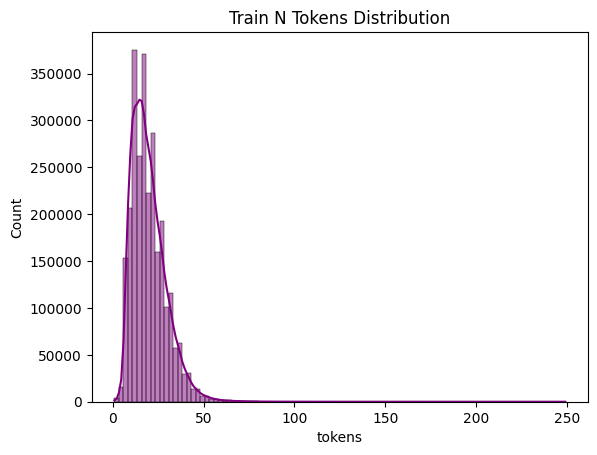

0.95 Quantile of N tokens: 37.0


In [41]:
train_n_tokens = geo_processed_df["tokens"].apply(len)

plt.title("Train N Tokens Distribution")

# Use Seaborn's histplot function for the distribution plot
sns.histplot(train_n_tokens, bins=100, kde=True, color='purple')

plt.show()

print(f"0.95 Quantile of N tokens: {np.quantile(train_n_tokens, 0.95)}")


In [42]:
train_torch_dataset = TextTokenDataset(
    texts=geo_processed_df["tokens"].to_list(),
    targets=geo_processed_df["labels"].to_list(),
    dataset_vocab=vocab,
    max_length=50,
    # trim_policy="first"
)

train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [43]:
def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
#     device="cpu",
    device="cuda",
    skip_concat=False
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_text_ids = []
    all_losses = []
    all_targets = []
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            text, label = text.to(device), label.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            predicted_label = inp_model(text)
            loss = criterion(predicted_label, label)
            if mode == "train":
                loss.mean().backward()
                optimizer.step()
                
            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_text_ids.append(text.detach().cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())

    if not skip_concat:
        all_losses = np.concatenate(all_losses)
        all_text_ids = np.concatenate(all_text_ids)
        all_predicted_label = np.concatenate(all_predicted_label)
        all_targets = np.concatenate(all_targets)
    
    return all_predicted_label, all_losses, all_targets, all_text_ids

In [44]:
class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=True,
        average_type=None,
        dropout_rate=0.4
    ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)
        self.rnns = rnn_type(
            rnn_channels, 
            rnn_channels, 
            bidirectional=bidirectional, 
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is nit supported average_type")
        self.average_type = average_type
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(
                rnn_channels * 2 if bidirectional else rnn_channels, 
                out_channels, 
            )
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            # Dimension reminder : [Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x

In [45]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    rnn_channels=512,
    n_rnns=5,
    out_channels=1,
    average_type=None,
    bidirectional=True,
    dropout_rate=0.2
).to(device)

#     bidirectional=True
#     If we turned this parameter False this would really make a difference. And here is why:

#     Unidirectional RNN:

# In a unidirectional RNN, the input sequence is processed from one direction (either from the beginning to the end or from the end to the beginning).
# It is suitable for tasks where past information is sufficient for predicting future information, or vice versa.
# For example, in sentiment analysis, reading the text from start to finish is usually enough to understand the sentiment of the text.

# Bidirectional RNN:

# In a bidirectional RNN, the input sequence is processed in both directions simultaneously: from the beginning to the end and from the end to the beginning.
# It captures context from both past and future information. This can be particularly useful for tasks where context from both directions is important.
# Bidirectional RNNs are often used for tasks like named entity recognition, where understanding a word might require information from both the past and the future in the sequence.
    
#     For a deeper explanation read this article:
#     https://www.baeldung.com/cs/bidirectional-vs-unidirectional-lstm

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.0013)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)
# patience = 0 no need to change. we already  too few epochs to train a model with

In [46]:
train_torch_dataset = TextTokenDataset(
    texts=geo_processed_df.iloc[folds_train_test_ids[0][0]]["tokens"].to_list(),
    targets=geo_processed_df.iloc[folds_train_test_ids[0][0]]["labels"].to_list(),
    dataset_vocab=vocab,
    max_length=50,
)
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

valid_torch_dataset = TextTokenDataset(
    texts=geo_processed_df.iloc[folds_train_test_ids[0][1]]["tokens"].to_list(),
    targets=geo_processed_df.iloc[folds_train_test_ids[0][1]]["labels"].to_list(),
    dataset_vocab=vocab,
    max_length=50,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

In [47]:
# Create by Chat GPT: https://chat.openai.com/share/1ebda1cb-c708-4e2b-ac63-b89e26ea4f1c

def extract_token_sequences(tensor, text_ids):
    extracted_texts = []

    # Add a False column at the beginning and end for detecting regions at boundaries
    tensor = np.column_stack((np.zeros(tensor.shape[0], dtype=bool), tensor, np.zeros(tensor.shape[0], dtype=bool)))

    for i, sequence in enumerate(tensor):
        # Find indices where values change
        diff = np.where(sequence[:-1] != sequence[1:])[0]
        
        sequence_texts = []
        for j in range(0, len(diff), 2):
            start, end = diff[j], diff[j+1]-1
            # Extract the token ids for the region and join them with "_"
            sequence_texts.append("_".join(map(str, text_ids[i, start:end+1])))
        
        extracted_texts.append(sequence_texts)

    return extracted_texts

def apply_connected_regions_and_compute_metric(
    y_true,
    y_pred,
    texts,
    tresh=0.5
):
    real_tokens = extract_token_sequences(
        y_true[:,:,0] > 0.5,
        texts
    )
    pred_tokens = extract_token_sequences(
        y_pred[:,:,0] > tresh,
        texts
    )

    return comp_metric(real_tokens, pred_tokens)

# Create by Chat GPT: https://chat.openai.com/share/9d985a97-0cce-44d8-be51-c571c1cd1efc

def find_connected_components_test(arr_list):
    """
    Finds connected components in a list of 1D boolean numpy arrays.

    Parameters:
        arr_list (list of numpy arrays): List of 1D boolean arrays

    Returns:
        list of lists of tuples: Each list corresponds to the given 1D array. 
                                 Each tuple in the inner list represents the start and end indices of a connected component.
    """
    components_list = []

    for arr in arr_list:
        padded_arr = np.insert(arr, [0, arr.size], [False, False])
        diff = np.diff(padded_arr.astype(int))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]  # Not subtracting 1 anymore

        components_list.append(list(zip(starts, ends)))

    return components_list

def get_precise_text_spans(original_text, tokens, token_spans):
    """
    Convert token spans to precise text spans based on the original text.

    Parameters:
        original_text (str): The original, non-tokenized text.
        tokens (list of str): List of tokens.
        token_spans (list of tuple): List of start and end indices for the tokens.

    Returns:
        list of tuple: List of start and end indices for the combined text using Python slicing semantics.
    """
    
    positions = []
    last_index = 0
    for token in tokens:
        # Search for the next occurrence of the token in the original text.
        start_idx = original_text.find(token, last_index)
        if start_idx == -1:
            # Try without leading or trailing punctuation
            token_stripped = token.strip('.,«»"()[]{}:;')
            start_idx = original_text.find(token_stripped, last_index)
            if start_idx == -1:
                raise ValueError(f"Token '{token}' not found in the original text after index {last_index}")
        end_idx = start_idx + len(token)
        positions.append((start_idx, end_idx))
        last_index = end_idx

    # Map token spans to text spans based on the positions found.
    text_spans = []
    for start, end in token_spans:
        if start >= len(positions) or end > len(positions):
            raise ValueError(f"Invalid token span ({start}, {end}). Exceeds length of tokens.")
        text_spans.append((positions[start][0], positions[end-1][1]))

    return text_spans

In [ ]:
# Initialize lists to store ROC-AUC and Precision-Recall AUC for each epoch
# roc_auc_scores = []
# pr_auc_scores = []

n_epochs = 4

train_all_epoch_losses = []
valid_all_epoch_losses = []
valid_metrics = []

best_metric = {
    "f1": - np.inf,
}
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    _, train_epoch_losses, _, _ = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=device,
        mode="train"
    )
    # 1.2 Compute and print train metrics
    # Skip Train Metric in order to speed up training loop
    print("Train BCE loss:", train_epoch_losses.mean())
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets, valid_epoch_texts = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=device,
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    valid_metric = apply_connected_regions_and_compute_metric(
        valid_epoch_targets, 
        valid_epoch_labels,
        valid_epoch_texts,
        tresh=0.5
    )
    print("Valid metric:", valid_metric)
    print("Valid BCE loss:", valid_epoch_losses.mean())
    # 3. Update learning rate (if needed)
    scheduler.step(valid_metric["f1"])
    # 4. Save best model
    if valid_metric["f1"] > best_metric["f1"]:
        best_metric = valid_metric
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate some stats  
    train_all_epoch_losses.append(train_epoch_losses)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_metrics.append(valid_metric)


Starting Epoch 1
Train phase


  4%|▍         | 2998/67500 [08:16<2:57:42,  6.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|█▏        | 7743/67500 [21:15<2:43:59,  6.07it/s]

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.title("Validation Metrics Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)

plt.plot([el["f1"] for el in valid_metrics], label="F1 Score", marker='o', linestyle='-', linewidth=2)
plt.plot([el["precision"] for el in valid_metrics], label="Precision", marker='s', linestyle='--', linewidth=2)
plt.plot([el["recall"] for el in valid_metrics], label="Recall", marker='^', linestyle='-.', linewidth=2)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [ ]:
# # Plot ROC-AUC and Precision-Recall AUC over epochs
# plt.figure(figsize=(10, 6))
# plt.title("ROC-AUC and Precision-Recall AUC Over Epochs", fontsize=16)
# plt.xlabel("Epoch", fontsize=12)
# plt.ylabel("AUC Value", fontsize=12)

# plt.plot(roc_auc_scores, label="ROC-AUC", marker='o', linestyle='-', linewidth=2)
# plt.plot(pr_auc_scores, label="Precision-Recall AUC", marker='s', linestyle='--', linewidth=2)

# plt.legend(fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.7)

# plt.show()

In [ ]:
SAVE_PATH = '/kaggle/working/best_model_state_dict.pth'

torch.save(best_model_state_dict, SAVE_PATH)

In [ ]:
# Load best model
nn_model.load_state_dict(best_model_state_dict)

In [ ]:

test_torch_dataset = TextTokenDataset(
    texts=geo_processed_df_hodlout_test["tokens"].to_list(),
    targets=geo_processed_df_hodlout_test["labels"].to_list(),
    dataset_vocab=vocab,
    max_length=None,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

In [ ]:
test_labels, test_losses, test_targets, test_texts = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device=device,
    mode="eval",
    skip_concat=True
)

In [ ]:
print("Holdout Test Mean Loss:", np.concatenate(test_losses, axis=1).mean())

In [ ]:
test_prediction_token_spans = find_connected_components_test([el.squeeze() > 0.5 for el in test_labels])
test_prediction_text_spans = [
    get_precise_text_spans(
        text_sample, 
        tokens, 
        spans
    ) for text_sample, tokens, spans in zip(
        geo_dataset_hodlout_test.text, 
        geo_processed_df_hodlout_test.tokens, 
        test_prediction_token_spans
    )
]

In [ ]:
geo_dataset_hodlout_pred = pd.DataFrame({
    "text": geo_dataset_hodlout_test.text,
    "loc_markers": test_prediction_text_spans
})

In [ ]:
test_real_locations = geo_dataset_hodlout_test.apply(lambda row: [row["text"][l_idx:r_idx] for l_idx, r_idx in row["loc_markers"]], axis=1)
test_prediction_locations = geo_dataset_hodlout_pred.apply(lambda row: [row["text"][l_idx:r_idx] for l_idx, r_idx in row["loc_markers"]], axis=1)

print(
    "Holdout Test Metric:", 
    comp_metric(
        test_real_locations.to_list(),
        test_prediction_locations
    )
)

In [ ]:
sample_id_with_many_locs = np.argsort([len(el) for el in test_prediction_locations])[-3]
print(
    "Text:", geo_dataset_hodlout_test.iloc[sample_id_with_many_locs].text,
    "\nReal locations:", test_real_locations[sample_id_with_many_locs],
    "\nPredicted locations:", test_prediction_locations[sample_id_with_many_locs],
    "\nSample Score:", comp_metric([test_real_locations[sample_id_with_many_locs]], [test_prediction_locations[sample_id_with_many_locs]])
)

In [ ]:
kaggle_test = pd.read_csv(test_path, converters={"locations": eval})

In [ ]:
kaggle_test

In [ ]:
def batch_ner_labeling(texts, loc_markers_list, tokenizer, batch_size=128, n_process=16, verbose=False):
    if verbose:
        print("Applying Tokenizer")
    docs = list(tokenizer.pipe(texts, batch_size=batch_size, n_process=n_process))
    batch_results = []

    if verbose:
        print("Extracting labels")
    for doc, loc_markers in zip(docs, loc_markers_list):
        tokens = [token.text for token in doc]
        labels = ['O'] * len(tokens)
        
        for idx, token in enumerate(doc):
            for start, end in loc_markers:
                if token.idx >= start and (token.idx + len(token.text)) <= end:
                    labels[idx] = 'LOC'
                    break
        
        batch_results.append((tokens, labels))
                
    return batch_results

kaggle_test_processed_dataset = batch_ner_labeling(kaggle_test.text.to_list(), kaggle_test.locations.to_list(), nlp, verbose=True)

In [ ]:
kaggle_test_torch_dataset = TextTokenDataset(
    texts=[el[0] for el in kaggle_test_processed_dataset],
    targets=[el[1] for el in kaggle_test_processed_dataset],
    dataset_vocab=vocab,
    max_length=None,
    trim_policy="first"
)
kaggle_test_torch_dataloader = torch.utils.data.DataLoader(
    kaggle_test_torch_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

In [ ]:
kaggle_test_labels, _, _, _ = torch_loop(
    dataloader=kaggle_test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device=device,
    mode="eval",
    skip_concat=True
)

In [ ]:
kaggle_test_prediction_token_spans = find_connected_components_test([el[0,:,0] > 0.5 for el in kaggle_test_labels])
kaggle_test_prediction_text_spans = [
    get_precise_text_spans(
        text_sample, 
        tokens, 
        spans
    ) for text_sample, tokens, spans in zip(
        kaggle_test.text.to_list(), 
        [el[0] for el in kaggle_test_processed_dataset], 
        kaggle_test_prediction_token_spans
    )
]

In [ ]:
kaggle_test["loc_markers"] = kaggle_test_prediction_text_spans
kaggle_test["locations"] = kaggle_test.apply(lambda row: [row["text"][l_idx:r_idx] for l_idx, r_idx in row["loc_markers"]], axis=1)
sample_id_with_many_locs = np.argsort([len(el) for el in kaggle_test_prediction_text_spans])[-1]
print(
    "Text:", kaggle_test.iloc[sample_id_with_many_locs].text,
    "\nPredicted locations:", kaggle_test.iloc[sample_id_with_many_locs].locations,
)

In [ ]:
kaggle_test[["text_id", "locations"]].to_csv("practice4_rnn.csv", index=False)

In [ ]:
kaggle_test[["text_id", "locations"]]

In [ ]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "practice4_rnn.csv"):  
    csv = df[["text_id", "locations"]].to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


# create a link to download the dataframe
create_download_link(kaggle_test)